<a href="https://colab.research.google.com/github/wo7864/Calligrapick/blob/master/tensorflow_cvae_alphabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import module

In [0]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load data set

In [0]:
all_dataset = pd.read_csv('/content/gdrive/My Drive/data/A_Z Handwritten Data.csv').astype('float32')


### Edit data set

In [0]:
dataset = all_dataset.loc[all_dataset['0'] < 1] # a만 사용
dataset.rename(columns={'0':'label'}, inplace=True)
X = dataset.drop('label',axis = 1)
y = dataset['label']


# splite the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

X_train[:,:] = 1-X_train[:,:]

    


Iter: 0
Loss: 1.116e+03



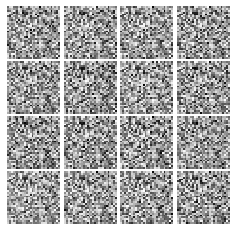

Iter: 10000
Loss: 79.91



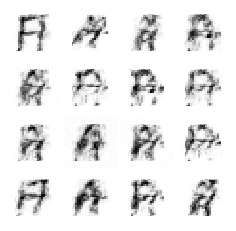

In [0]:



mb_size = 100
z_dim = 100
X_dim = X_train.shape[1]
y_dim = 1
h_dim = 128
c = 0
lr = 1e-3

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


# =============================== TRAINING ====================================
saver = tf.train.Saver()
z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer(lr).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(200001):
    X_mb = X_train[:100]
    y_mb = np.zeros(100).reshape(100,1)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()
        
        y = np.zeros(shape=[16, y_dim])
        y[:, np.random.randint(0, y_dim)] = 1.
        rand_z = np.random.rand(16, z_dim)

        samples = sess.run(X_samples,
                           feed_dict={z: rand_z, c: y})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show()
        i += 1
        plt.close(fig)
        if it == 200000:
          for i in range(16):
            print(rand_z[i])
          saver.save(sess, "/content/gdrive/My Drive/celligrapick/model/A.ckpt")
          f = open("/content/gdrive/My Drive/celligrapick/z_value/A.txt", 'w')
          f.write(rand_z)
        
 

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
